### Overview of this notebook

This notebook walks through the full process of building an employee attrition model and choosing a final version for deployment.

In simple terms, here is what happens:

1. **Understand the data**: load the attrition dataset and look at basic info and first rows.
2. **Explore patterns**: check which groups of employees leave more often (by overtime, department, job role, etc.).
3. **Prepare the data**: scale numeric features and encode categorical ones so that models can use them.
4. **Train base models**: try Logistic Regression and Random Forest on the original data.
5. **Fix class imbalance with SMOTE**: balance the target so the model can learn to detect leavers better.
6. **Inspect feature importance**: see which features push the prediction up or down.
7. **Save the final model**: keep the Logistic Regression + SMOTE model and the preprocessor to serve via an API.

The main goal is **not just high accuracy**, but to **catch as many true leavers as possible**, so we focus on metrics like Recall and ROC-AUC when picking the final model.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../csv/attrition.csv")
df.sample(n=5)


,age,gender,education,department,job_role,monthly_income,years_at_company,promotions,overtime,performance_rating,attrition
162,44,Female,Post-Graduate,Sales,Executive,86081,4,2,No,4,0
263,55,Female,Post-Graduate,HR,Manager,54701,7,4,No,3,0
287,44,Female,Post-Graduate,Sales,Executive,23972,1,4,No,1,0
158,38,Female,PhD,IT,Executive,94859,3,1,No,2,0
279,58,Female,Post-Graduate,IT,Lead,78762,1,2,No,1,0


In [3]:
print(df.shape)
print(df.columns.tolist())
print(df.head())
print(df.info())
print(df.isna().sum())

(300, 11)
['age', 'gender', 'education', 'department', 'job_role', 'monthly_income', 'years_at_company', 'promotions', 'overtime', 'performance_rating', 'attrition']
   age  gender      education department   job_role  monthly_income  \
0   50  Female  Post-Graduate         IT       Lead          102565   
1   36  Female            PhD      Sales       Lead           49402   
2   29  Female       Graduate         HR  Executive           24263   
3   42    Male       Graduate         HR  Executive          116523   
4   40  Female            PhD         HR    Manager           66828   

   years_at_company  promotions overtime  performance_rating  attrition  
0                 9           0       No                   1          0  
1                 2           0      Yes                   2          0  
2                 7           1       No                   1          0  
3                 7           3      Yes                   4          0  
4                 1           1      

### First look at attrition and feature patterns

In the next few cells I explore how attrition behaves in the dataset:

- I start by plotting the **overall distribution of attrition** to see how many people stayed vs left.
- Then I look at how **numeric features** (age, monthly income, years at company, promotions, performance rating) differ between employees who stayed and those who left.
- I also check **categorical features** (gender, education, department, job_role, overtime) to see which groups have higher attrition rates.

These plots show that some groups, like people who work **overtime** or those in certain **departments or roles** (for example HR and Managers), have higher chances of leaving. This guides which features we expect to be important later in the model.


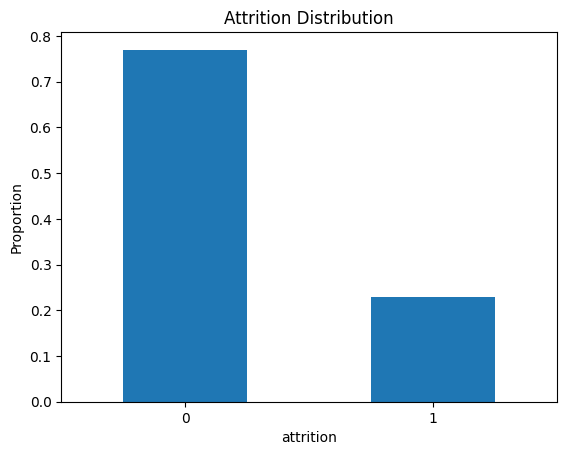

In [4]:
attrition_counts = df['attrition'].value_counts(normalize=True)

plt.figure()
attrition_counts.plot(kind='bar')
plt.title("Attrition Distribution")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()


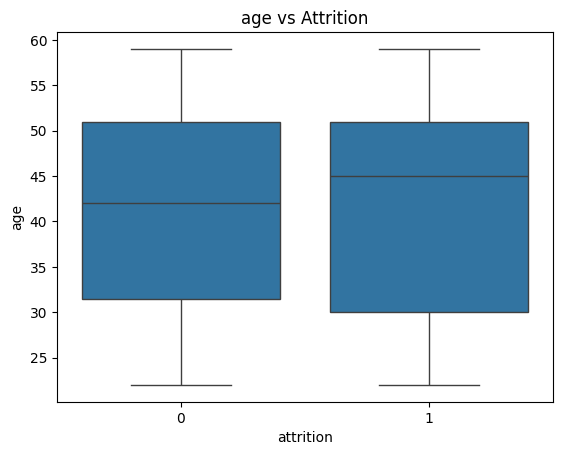

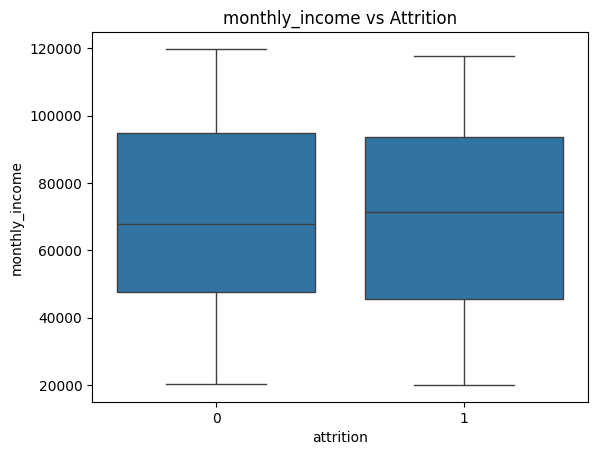

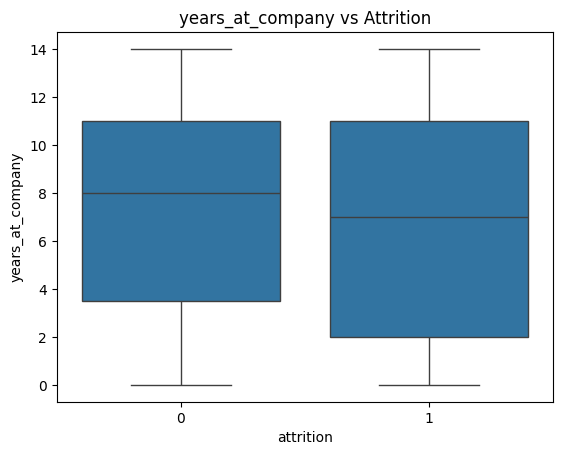

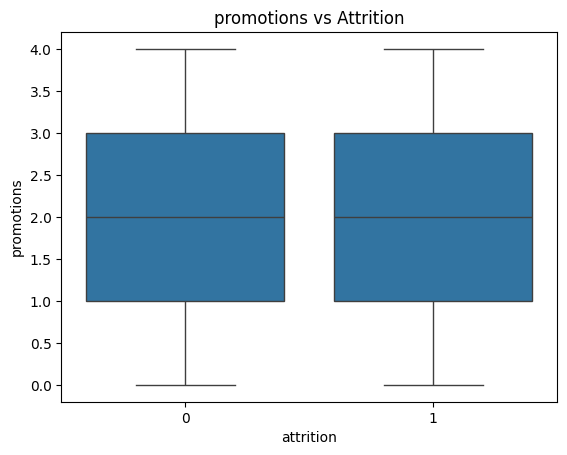

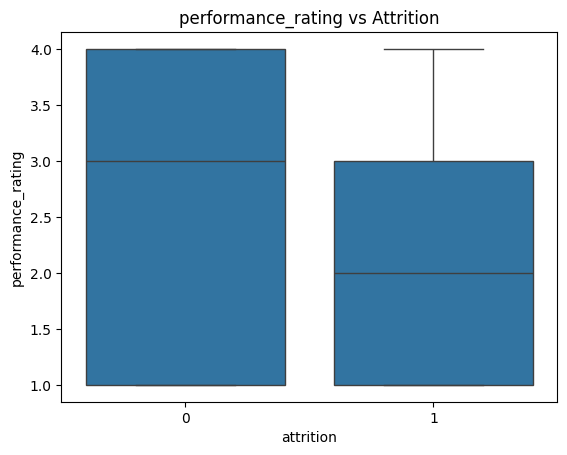

In [5]:
num_cols = [
    'age',
    'monthly_income',
    'years_at_company',
    'promotions',
    'performance_rating'
]

for col in num_cols:
    plt.figure()
    sns.boxplot(x='attrition', y=col, data=df)
    plt.title(f"{col} vs Attrition")
    plt.show()


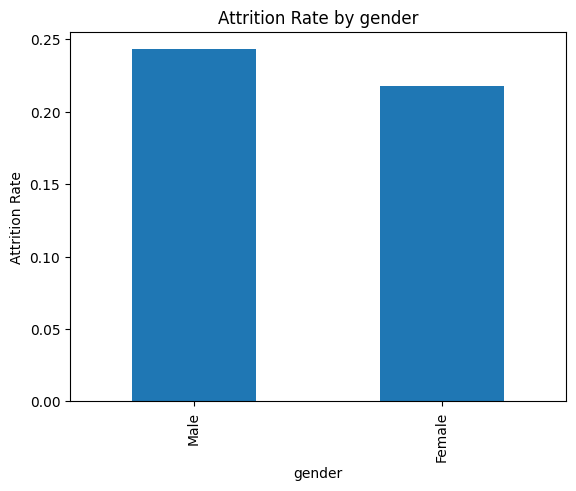

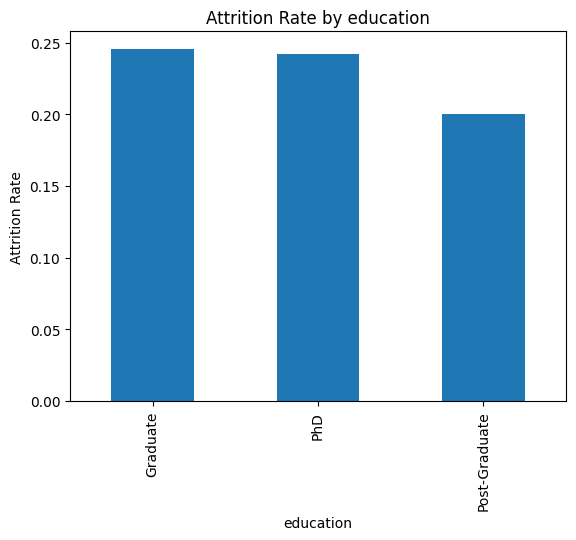

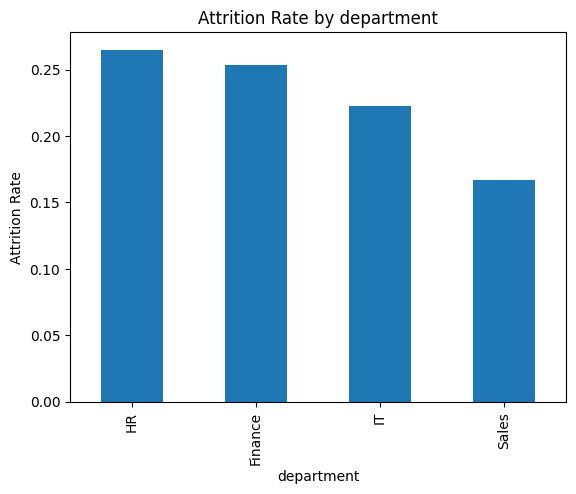

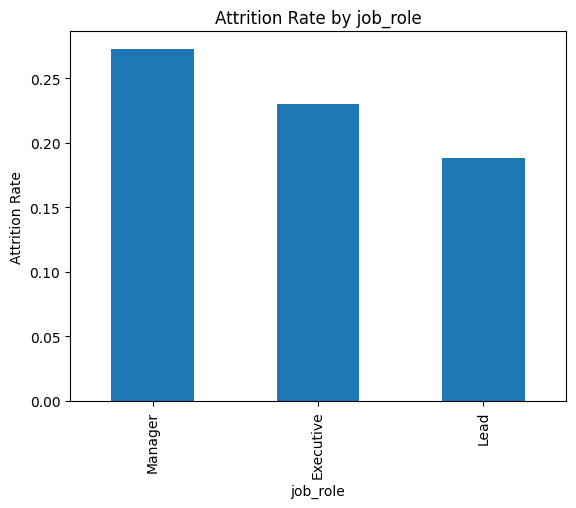

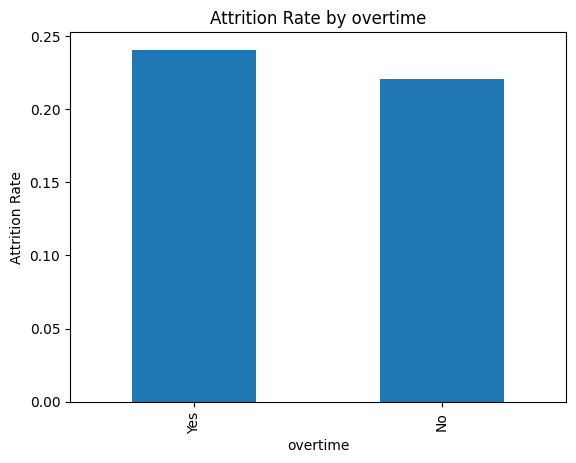

In [6]:
cat_cols = [
    'gender',
    'education',
    'department',
    'job_role',
    'overtime'
]

for col in cat_cols:
    attrition_rate = df.groupby(col)['attrition'].mean().sort_values(ascending=False)

    plt.figure()
    attrition_rate.plot(kind='bar')
    plt.title(f"Attrition Rate by {col}")
    plt.ylabel("Attrition Rate")
    plt.show()


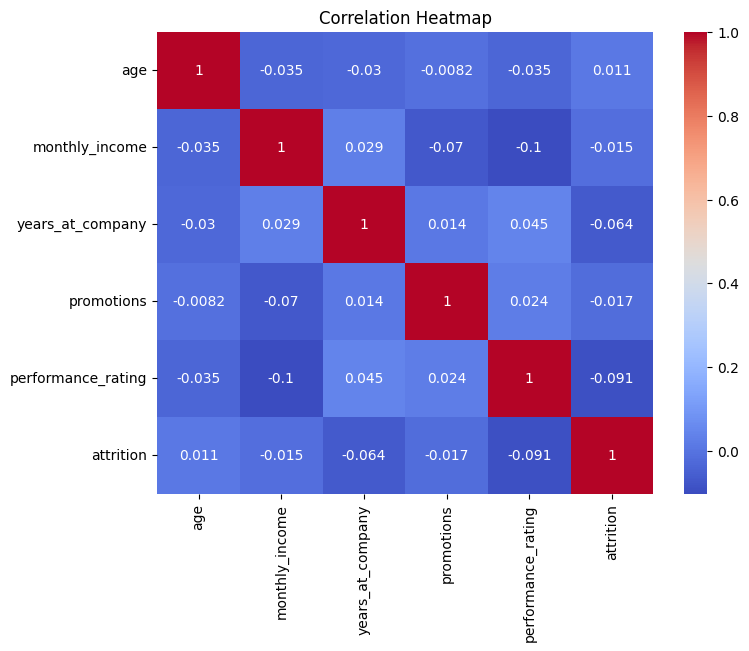

In [7]:
plt.figure(figsize=(8,6))
corr = df[num_cols + ['attrition']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

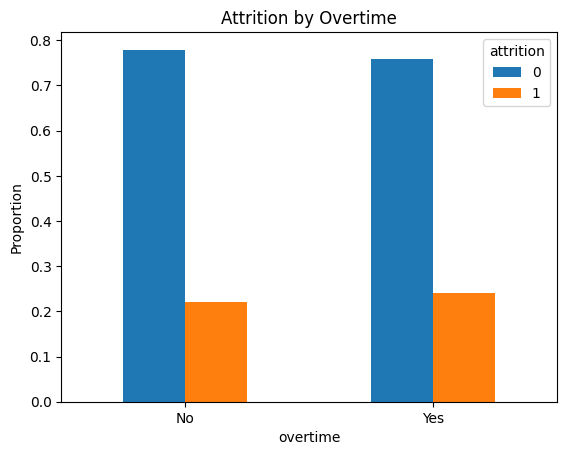

In [8]:
overtime_attrition = pd.crosstab(df['overtime'], df['attrition'], normalize='index')

overtime_attrition.plot(kind='bar')
plt.title("Attrition by Overtime")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()


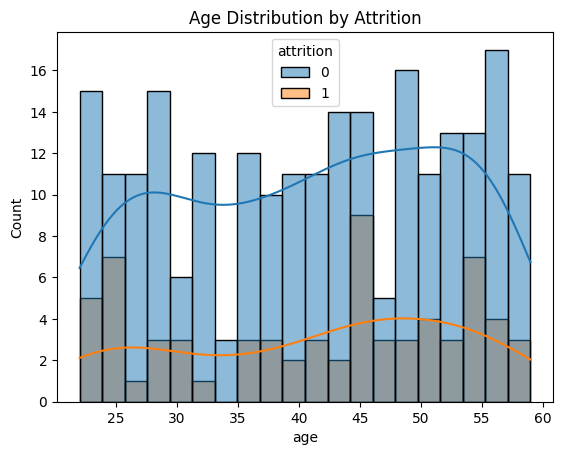

In [9]:
plt.figure()
sns.histplot(data=df, x='age', hue='attrition', bins=20, kde=True)
plt.title("Age Distribution by Attrition")
plt.show()

In [10]:
X = df.drop('attrition', axis=1)
y = df['attrition']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (300, 10)
Target shape: (300,)


In [11]:
num_cols = [
    'age',
    'monthly_income',
    'years_at_company',
    'promotions',
    'performance_rating'
]

cat_cols = [
    'gender',
    'education',
    'department',
    'job_role',
    'overtime'
]

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train attrition rate:", y_train.mean())
print("Test attrition rate:", y_test.mean())


Train attrition rate: 0.2311111111111111
Test attrition rate: 0.22666666666666666


### Building the preprocessing pipeline

Before training any model, I prepare the data so that all features are in a good shape for learning:

- For **numeric columns** (like age, monthly income, years at company), I use **StandardScaler** so that they all have a similar scale.
- For **categorical columns** (like gender, department, job_role, overtime), I use **OneHotEncoder** to turn each category into numbers.

I wrap these steps inside a **ColumnTransformer** called `preprocessor`. This makes the pipeline clean and repeatable, and it also lets me save this exact transformation later for the API.


In [13]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_transformer = StandardScaler()

cat_transformer = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse_output=False
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ],
    verbose_feature_names_out=False
)

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed train shape:", X_train_processed.shape)
print("Processed test shape:", X_test_processed.shape)

Processed train shape: (225, 14)
Processed test shape: (75, 14)


In [15]:
feature_names = list(num_cols) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed shape:", X_train_df.shape)
print("Data type:", type(X_train_processed))

Processed shape: (225, 14)
Data type: <class 'numpy.ndarray'>


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }

### Training the first models (before SMOTE)

Now I train two different models on the processed data
For each model I check several metrics:

- **Accuracy**: overall percent of correct predictions.
- **Recall**: among the people who actually left, how many did we correctly catch?
- **ROC-AUC**: how well the model separates leavers vs non-leavers across all thresholds.

These base results help me see that Random Forest has high accuracy but fails badly on Recall, which is a problem if we care about catching real attrition cases.


In [17]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
)

log_reg.fit(X_train_processed, y_train)

logreg_results = evaluate_model(
    log_reg,
    X_test_processed,
    y_test
)

logreg_results

{'Accuracy': 0.5733333333333334,
 'Precision': np.float64(0.2413793103448276),
 'Recall': np.float64(0.4117647058823529),
 'F1': np.float64(0.30434782608695654),
 'ROC-AUC': np.float64(0.5223123732251521)}

In [18]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train_processed, y_train)

rf_results = evaluate_model(
    rf,
    X_test_processed,
    y_test
)

rf_results

c:\Users\REESAV\Desktop\New folder\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.7733333333333333,
 'Precision': np.float64(0.0),
 'Recall': np.float64(0.0),
 'F1': np.float64(0.0),
 'ROC-AUC': np.float64(0.4731237322515213)}

### Fixing the class imbalance with SMOTE

Earlier we saw that the dataset is **imbalanced**: there are many more employees who stay (attrition = 0) than those who leave (attrition = 1).

- Because of this, the **Random Forest** model looked good on accuracy but had **Recall = 0.0**, meaning it did not correctly catch any of the people who actually left.
- To fix this, I use **SMOTE (Synthetic Minority Over-sampling Technique)** to create synthetic examples of the minority class (people who left).

After applying SMOTE and training again:

- **Logistic Regression (SMOTE)**: Accuracy = 0.573, Recall = 0.588, ROC-AUC = 0.641
- **Random Forest (SMOTE)**: Accuracy = 0.760, Recall = 0.058, ROC-AUC = 0.497

Even though accuracy is not the highest, **Logistic Regression with SMOTE** gives the best **Recall** and **ROC-AUC**, which are more important for our real-world goal: **finding employees at risk of leaving**. That is why this model is chosen for deployment.


In [19]:
# %pip uninstall scikit-learn --yes
# %pip uninstall imblearn --yes
# %pip install scikit-learn==1.2.2
# %pip install imblearn

from imblearn.over_sampling import SMOTE
try:
    smote = SMOTE(random_state=42)
    res = smote.fit_resample(X_train_df, y_train)
    X_train_smote = res[0]
    y_train_smote = res[1]
except ImportError:
    X_train_smote, y_train_smote = X_train_df, y_train

In [23]:
log_reg_smote = LogisticRegression(
    max_iter=1000,
    random_state=42
)

log_reg_smote.fit(X_train_smote, y_train_smote)

logreg_smote_results = evaluate_model(
    log_reg_smote,
    X_test_df,
    y_test
)

logreg_smote_results

{'Accuracy': 0.5733333333333334,
 'Precision': np.float64(0.2857142857142857),
 'Recall': np.float64(0.5882352941176471),
 'F1': np.float64(0.38461538461538464),
 'ROC-AUC': np.float64(0.6419878296146044)}

In [22]:
rf_smote = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_smote.fit(X_train_smote, y_train_smote)

rf_smote_results = evaluate_model(
    rf_smote,
    X_test_df,
    y_test
)

rf_smote_results

{'Accuracy': 0.76,
 'Precision': np.float64(0.3333333333333333),
 'Recall': np.float64(0.058823529411764705),
 'F1': np.float64(0.1),
 'ROC-AUC': np.float64(0.4974645030425964)}

### Understanding which features drive attrition

Here I look at the **coefficients** of the Logistic Regression model that was trained on the SMOTE-balanced data.

- Positive coefficients mean the feature **increases** the chance of attrition.
- Negative coefficients mean the feature **decreases** the chance of attrition.

I sort the features by the absolute size of their coefficient so that I can see the strongest drivers first. In the results, features like **`overtime_Yes`** show up as important, confirming that working overtime is linked with a higher chance of leaving the company.


In [ ]:
import pandas as pd
import numpy as np

feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": log_reg_smote.coef_[0]
})

feature_importance["Abs_Coefficient"] = np.abs(feature_importance["Coefficient"])

feature_importance = feature_importance.sort_values(
    by="Abs_Coefficient",
    ascending=False
)

feature_importance.head(10)


,Feature,Coefficient,Abs_Coefficient
10,department_Sales,-0.732067,0.732067
7,education_Post-Graduate,-0.363522,0.363522
11,job_role_Lead,-0.301905,0.301905
6,education_PhD,-0.246418,0.246418
5,gender_Male,0.198974,0.198974
1,monthly_income,-0.196263,0.196263
4,performance_rating,-0.119464,0.119464
2,years_at_company,-0.117634,0.117634
0,age,0.099914,0.099914
3,promotions,-0.077713,0.077713


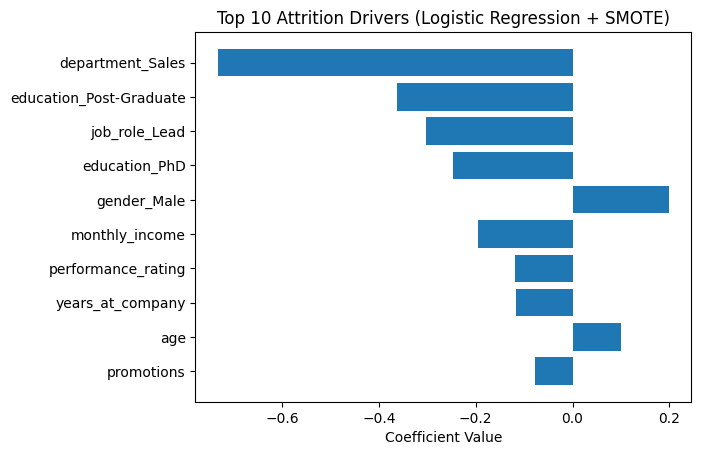

In [25]:
import matplotlib.pyplot as plt

top_features = feature_importance.head(10)

plt.figure()
plt.barh(top_features["Feature"], top_features["Coefficient"])
plt.title("Top 10 Attrition Drivers (Logistic Regression + SMOTE)")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.show()


### Saving the model and preprocessor

In this last step I am saving two important pieces:

- **Preprocessor**: this contains all the scaling and encoding logic. It makes sure that any new data we send to the model is transformed in the exact same way as the training data.
- **Final model (Logistic Regression + SMOTE)**: this is the model that performed best for our goal of catching employees who are likely to leave.

By saving both, I can later load them in a FastAPI app and get predictions directly from raw employee data, without having to repeat all the notebook steps.


In [ ]:
import pickle
import os

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# saving the preprocessor 
preprocessor_path = os.path.join(model_dir, 'preprocessor.pkl')
with open(preprocessor_path, 'wb') as f:
    pickle.dump(preprocessor, f)
print(f"Preprocessor saved to: {preprocessor_path}")

# saving the best model LogReg + SMOTE
model_path = os.path.join(model_dir, 'log_reg_smote_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(log_reg_smote, f)
print(f"Model saved to: {model_path}")

Preprocessor saved to: models\preprocessor.pkl
Model saved to: models\log_reg_smote_model.pkl
